## Example of active learning

Following this post:

https://towardsdatascience.com/active-learning-5b9d0955292d

### What is active learning?

Active learning is a machine learning technique in which we use less labelled data and interactively label new data points to improve the performance of the model.

Terminology:
* Train dataset = Labelled data points
* Pool = Unlabelled data points

We start with some labelled data points (train dataset). There is a large pool of unlabelled data points. These unlabelled data points have to be labelled and added to the train dataset to create the model. However, instead of labelling all the data points from the pool, we will label only a small number of them in active learning, but, still get a good performance.

We create a model (classifier) and train it on the labelled data. Then, we go through all the data points in the pool and identify the points that are most ambiguous for the classifier and add these points to the train data (We may add just a single point each time). We repeat this process to improve model performance. This technique is generally used when the labelling cost is high.

### Data

Iris Species: Classify iris plants into three species in this classic dataset

https://www.kaggle.com/datasets/uciml/iris?resource=download

## Setup

In [1]:
from sklearn.svm import SVC, LinearSVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

## Read Data

In [2]:
origdata = pd.read_csv("data/Iris.csv")
origdata.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


This dataset contains data about 3 species/subspecies of the Iris flower. Each sample has the length of the sepal, width of the sepal, the length of the petal and the width of the petal, all in centimetres. Each sample is of one of these three species — Iris setosa, Iris versicolor and Iris virginica.

## Data Preparation

We choose two of the attributes (columns) from the dataset for performing active learning. We have taken two columns because it is easy to visualize 2D data. However, note that taking only 2 columns may not be better than taking all the columns for machine learning or active learning.

In [3]:
k1, k2 = 'PetalLengthCm', 'PetalWidthCm'
data = origdata[[k1, k2, 'Species']].copy()
data.head()

,PetalLengthCm,PetalWidthCm,Species
0,1.4,0.2,Iris-setosa
1,1.4,0.2,Iris-setosa
2,1.3,0.2,Iris-setosa
3,1.5,0.2,Iris-setosa
4,1.4,0.2,Iris-setosa


For the training data, we take the two columns chosen earlier. The species column are the labels. We change the labels to 0 (for Iris-setosa), 1 (for Iris-versicolor) and 2 (for Iris-virginica).

In [4]:
X = data[[k1, k2]]
y = data['Species']
print('Classes:')
print(y.unique(), '\n\n\n')

y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
print(y.unique())

Classes:
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'] 



[0 1 2]


<ipython-input-4-8683252364e6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y=='Iris-setosa'] = 0
<ipython-input-4-8683252364e6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y=='Iris-versicolor'] = 1
<ipython-input-4-8683252364e6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y=='Iris-virginica'] = 2


We plot the samples of versicolor and virginica on a 2D graph with versicolor in red and virginica in cyan.

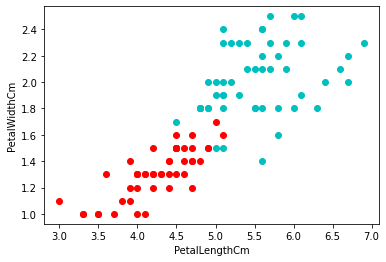

In [5]:
plt.figure()
setosa = y == 0
versicolor = y == 1
virginica = y == 2

plt.scatter(X[k1][versicolor], X[k2][versicolor], c='r')
plt.scatter(X[k1][virginica], X[k2][virginica], c='c')
plt.xlabel(k1)
plt.ylabel(k2)
plt.show()

We discard the samples of Iris-setosa.

In [6]:
X1 = X[y != 0]
y1 = y[y != 0]
X1[:5]

,PetalLengthCm,PetalWidthCm
50,4.7,1.4
51,4.5,1.5
52,4.9,1.5
53,4.0,1.3
54,4.6,1.5


Then, we reset the indexes of the dataframes.

In [7]:
X1 = X1.reset_index(drop=True)
y1 = y1.reset_index(drop=True)
y1 -= 1
print(y1.unique())
X1[:5]

[0 1]


,PetalLengthCm,PetalWidthCm
0,4.7,1.4
1,4.5,1.5
2,4.9,1.5
3,4.0,1.3
4,4.6,1.5


We plot the data on a 2D graph and save the figure as ‘main.jpg’.

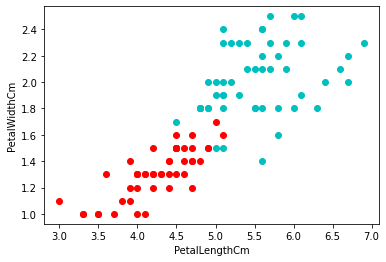

In [8]:
fig = plt.figure()

plt.scatter(X1[k1][y1==0], X1[k2][y1==0], c='r')
plt.scatter(X1[k1][y1==1], X1[k2][y1==1], c='c')

plt.xlabel(k1)
plt.ylabel(k2)
fig.savefig('main.jpg', dpi=100)
plt.show() 

We train a Linear SVM kernel on the entire data to understand the SVM model that we would get when using all the data. Since this is a linear SVM model, the decision boundary (the boundary separating the two classes) will be a straight line. We look at the slope and the intercept of the decision boundary.

In [9]:
y1 = y1.astype(dtype=np.uint8)
clf0 = LinearSVC()
clf0.fit(X1, y1)
#LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#          verbose=0)
print(clf0.coef_)
print(clf0.intercept_)

[[0.28015273 1.70097646]]
[-4.17110815]


Here, we plot the decision boundary along with all the data points. The decision boundary is a straight line in this case (because the model is a Linear SVM). ```clf0``` is the trained classifier (SVM). We get the coefficients from the ```clf0.coef_``` and ```clf0.intercept```. ```a0```, ```b0```, ```c0``` are the coefficients of the line (Line Equation: ```a0*x + b0*y + c0 = 0```; ```y = -(a0*x + c0)/b0```). We get 100 points on this line (lx0- has the x-corrdinates; ly0- has the y-coordinates) and plot them (a magenta line). Let us call this the ideal decision boundary (this may not be the ideal decision boundary for all SVMs when we use different kinds of SVM kernels, but, it will indeed be a good decision boundary).
Then, we plot all points in the dataset in cyan and red as per their classes.

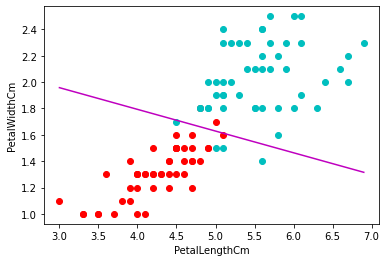

In [10]:
xmin, xmax = X1[k1].min(), X1[k1].max()
ymin, ymax = X1[k2].min(), X1[k2].max()
stepx = (xmax - xmin)/99
stepy = (ymax - ymin)/99

a0, b0, c0 = clf0.coef_[0, 0], clf0.coef_[0, 1], clf0.intercept_

# Formula for reference
# a*x + b*y + c = 0
# y = -(a*x + c)/b

lx0 = [xmin + stepx * i for i in range(100)]
ly0 = [-(a0*lx0[i] + c0)/b0 for i in range(100)]

plt.figure()

plt.scatter(X1[k1][y1==0], X1[k2][y1==0], c='r')
plt.scatter(X1[k1][y1==1], X1[k2][y1==1], c='c')

plt.plot(lx0, ly0, c='m')

plt.xlabel(k1)
plt.ylabel(k2)

plt.show()

Now, we split the dataset into two parts — pool(80%) and test(20%). We use a random state of 1. The split of the dataset is dependent on the random state.

In [11]:
X_pool, X_test, y_pool, y_test = train_test_split(X1, y1, test_size=0.2, random_state=1)
X_pool, X_test = X_pool.reset_index(drop=True), X_test.reset_index(drop=True)
y_pool, y_test = y_pool.reset_index(drop=True), y_test.reset_index(drop=True)
# random state 1 5 iterations

Let us apply the decision function of the SVM on two data points. Generally, for a two-class linear SVM, the decision function outputs positive values for one of the classes (one side of the decision boundary) and negative values for the other class (other side of the decision boundary) and zero on the decision boundary.
For a linear SVM, the magnitude of decision function is equal to the distance of the data point from the decision function. This is because, if a point is close to the decision boundary, then, it may be an outlier from the class on the other side of the decision boundary.

In [12]:
clf0.decision_function(X_pool.iloc[6:8])

array([1.67820356, 0.12131549])

Here, we see that the decision function has a negative value for one of the points and a positive value for the other point.

The function ```find_most_ambiguous``` gives the point that is the most ambiguous for the classifier. For an SVM classifier, if a data point is closer to the decision boundary and less ambiguous if the data point is farther from the decision boundary no matter which side of the decision boundary the point is on. Thus, ```find_most_ambiguous```, gives the unlabelled point that is the closest to the decision boundary.
```clf- classifier (trained SVM model); unknown_indexes- indexes from the dataset that are the unlabelled/unknown pool```

In [13]:
def find_most_ambiguous(clf, unknown_indexes):
    
    ind = np.argmin(np.abs( 
        list(clf.decision_function(X_pool.iloc[unknown_indexes]) )
        ))
    return unknown_indexes[ind]

The function, ```plot_svm```, is used to plot the following:
SVM decision boundary, the data points from the train data according to their class, and the data points in the unknown pool of samples.

* ```clf- classifier (trained SVM model)```
* ```train_indexes- Indexes of the dataset that are the train data points```
* ```unknown_indexes- Indexes of the dataset that are the unlabelled pool data points```
* ```title- The title of the plot```
* ```name- the name of the image file that when the plot is saved to a file```
* ```new_index- This is the index of the most ambiguous point in the unlabelled pool```

In this function, first, we get the train data ```(X_train, y_train)``` and the unlabelled data ```(X_unk, y_unk)``` from the train_indexes and unknown_indexes, respectively.

We plot all the unlabelled points from the pool in black. Then, we plot all the points from the train data in different colours (red and cyan) as per their class labels. We get the coefficients of the decision boundary (straight line) from the clf.coef_ and clf.intercept. Using this and the formula of a straight line, we plot this line (dashed green line). We also have the ideal decision boundary calculated earlier. This line is also plotted (in magenta).
Finally, we plot the ```new_index``` point, that is, the most ambiguous point (yellow star).

In [14]:
def plot_svm(clf, train_indexes, unknown_indexes, new_index = False, title = False, name = False):
    X_train = X_pool.iloc[train_indexes]
    y_train = y_pool.iloc[train_indexes]

    X_unk = X_pool.iloc[unknown_indexes]

    if new_index:
        X_new = X_pool.iloc[new_index]

    a, b, c = clf.coef_[0, 0], clf.coef_[0, 1], clf.intercept_
    # Straight Line Formula
    # a*x + b*y + c = 0
    # y = -(a*x + c)/b

    lx = [xmin + stepx * i for i in range(100)]
    ly = [-(a*lx[i] + c)/b for i in range(100)]

    fig = plt.figure(figsize=(9,6))

    # plt.scatter(x[k1][setosa], x[k2][setosa], c='r')
    plt.scatter(X_unk[k1], X_unk[k2], c='k', marker = '.')
    plt.scatter(X_train[k1][y_train==0], X_train[k2][y_train==0], c='r', marker = 'o')
    plt.scatter(X_train[k1][y_train==1], X_train[k2][y_train==1], c='c', marker = 'o')
    

    plt.plot(lx, ly, c='m')
    plt.plot(lx0, ly0, '--', c='g')

    if new_index:
        plt.scatter(X_new[k1], X_new[k2], c='y', marker="*", s=125)

    if title:
        plt.title(title)
    
    plt.xlabel(k1)
    plt.ylabel(k2)

    if name:
        fig.set_size_inches((9,6))
        plt.savefig(name, dpi=100)

    plt.show()

We take the first 10 indexes/data points of the pool as the initial train data and the rest 70 points as the unlabelled samples. We create the beginning plot with all the unlabelled samples, the ideal decision boundary and the 10 train data points.
Then, we train an SVM on the train data, and we find the most ambiguous point and create a new plot (“Iteration 0”) with this point as a yellow star and also plot the decision boundary of the trained SVM.

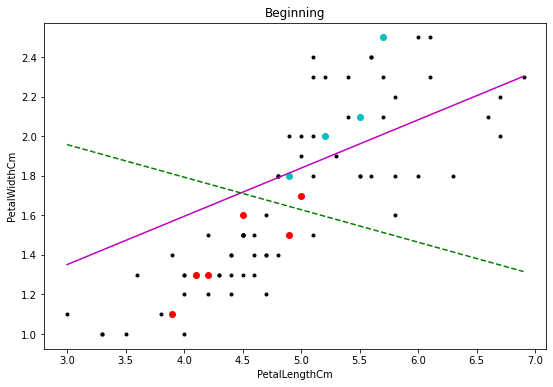

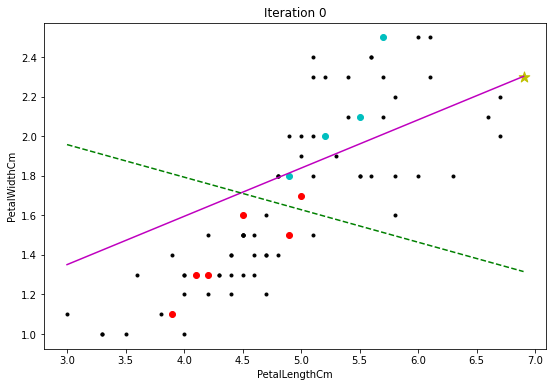

In [15]:
train_indexes = list(range(10))
unknown_indexes = list(range(10, 80))
X_train = X_pool.iloc[train_indexes]
y_train = y_pool.iloc[train_indexes]
clf = LinearSVC()
clf.fit(X_train, y_train)

# folder = "rs1it5/"
folder = "rs2it20/"
# folder = "rs1it20/"

try:
    os.mkdir(folder)
except:
    pass

filenames = ["ActiveLearningTitleSlide2.jpg"] * 2

title = "Beginning"
# name = folder + ("rs1it5_0a.jpg")
name = folder + ("rs2it20_0a.jpg")
plot_svm(clf, train_indexes, unknown_indexes, False, title, name)

filenames.append(name)

n = find_most_ambiguous(clf, unknown_indexes)
unknown_indexes.remove(n)

title = "Iteration 0"
name = folder + ("rs1it5_0b.jpg")
# name = folder + ("rs2it20_0b.jpg")
filenames.append(name)
plot_svm(clf, train_indexes, unknown_indexes, n, title, name)

Next, we run the active learning algorithm for 5 iterations. In each of them, we add the most ambiguous point to the training data and train an SVM, find the most unambiguous point at this stage and then create a plot all this.

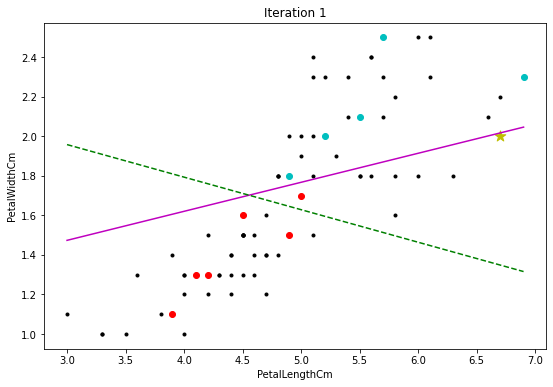

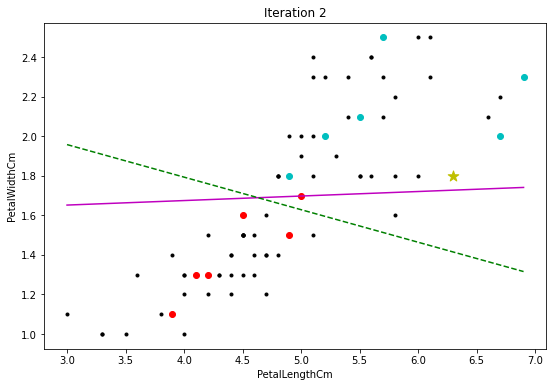

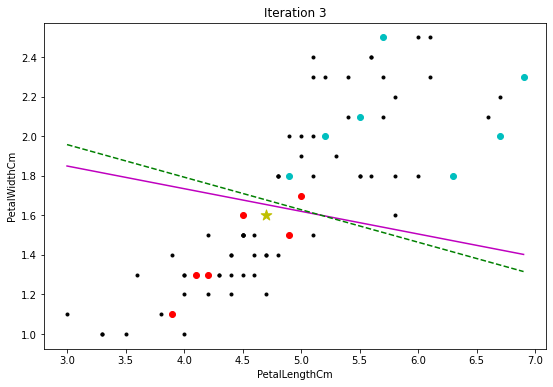

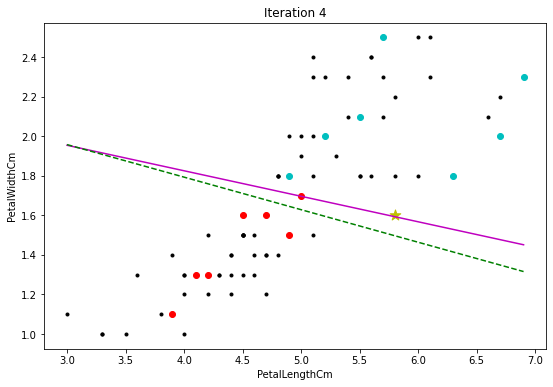

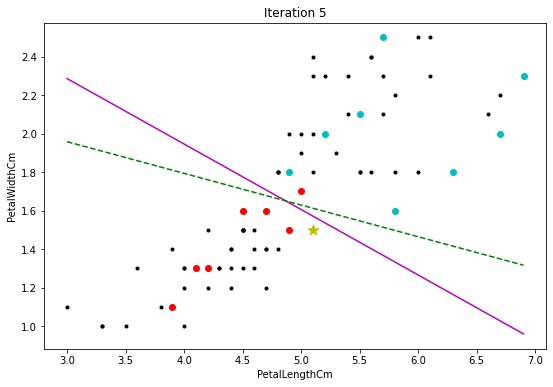

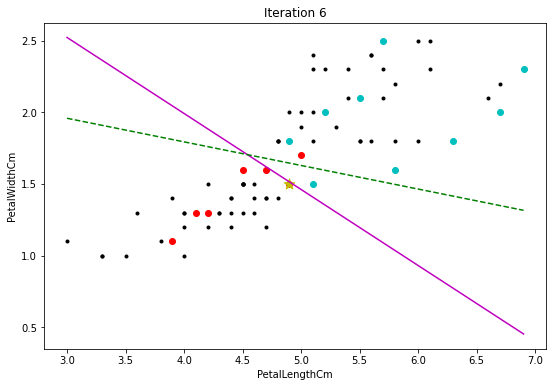

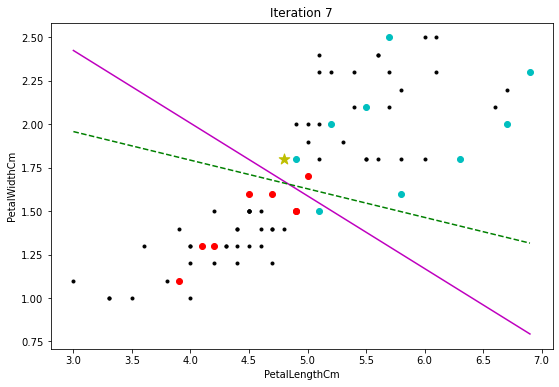

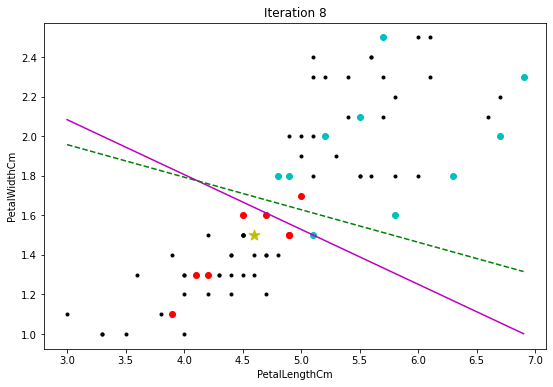

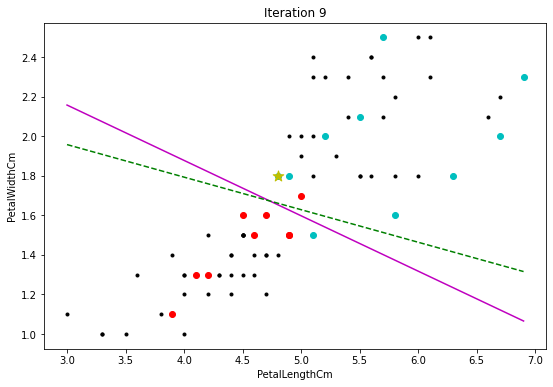

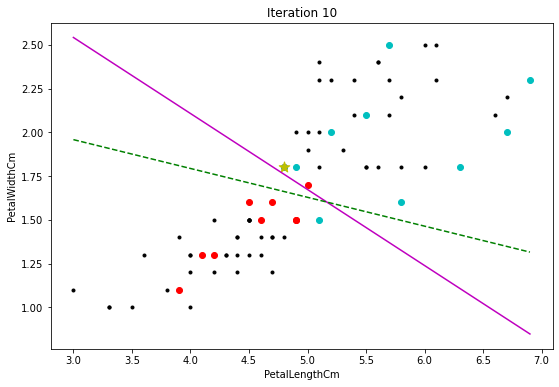

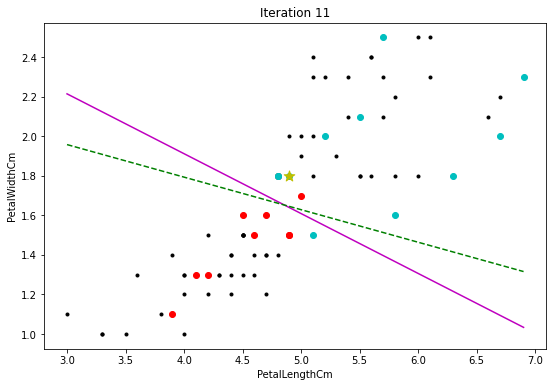

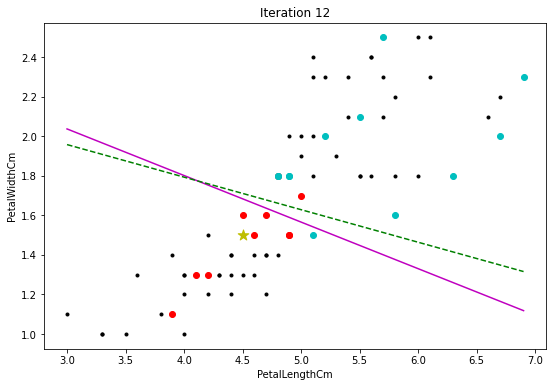

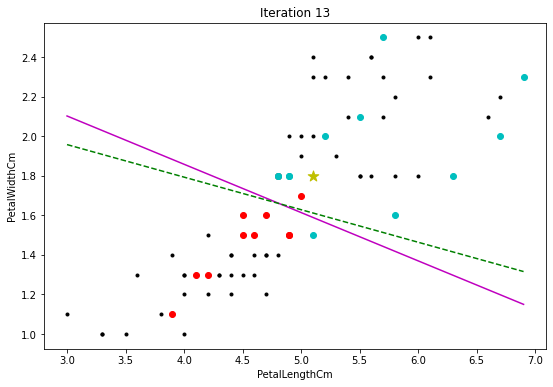

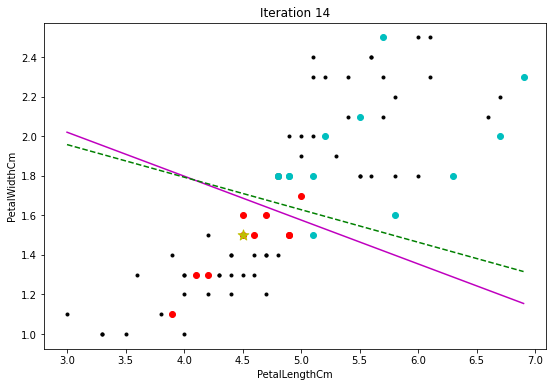

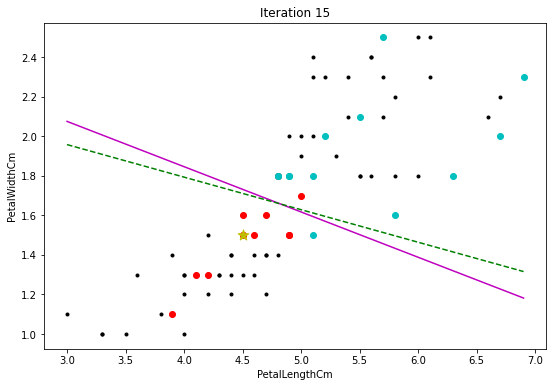

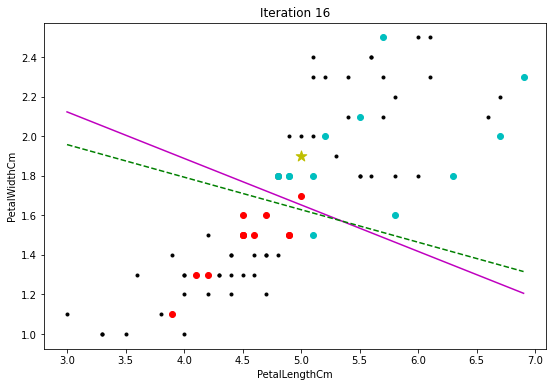

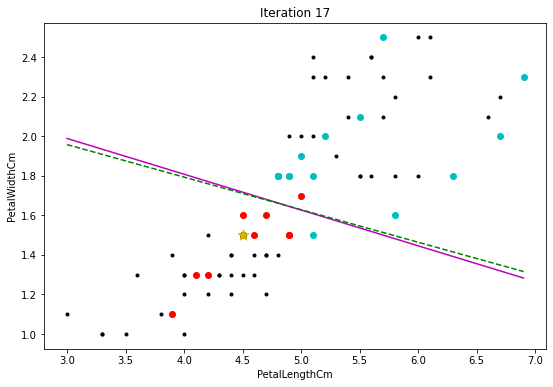

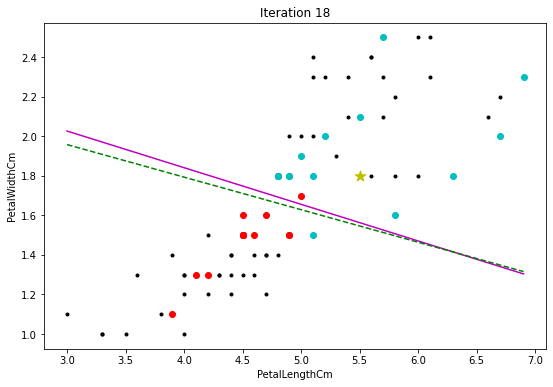

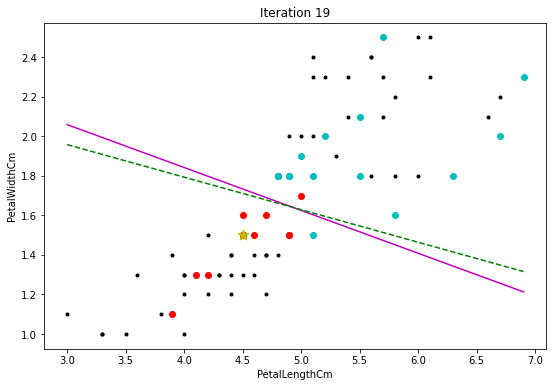

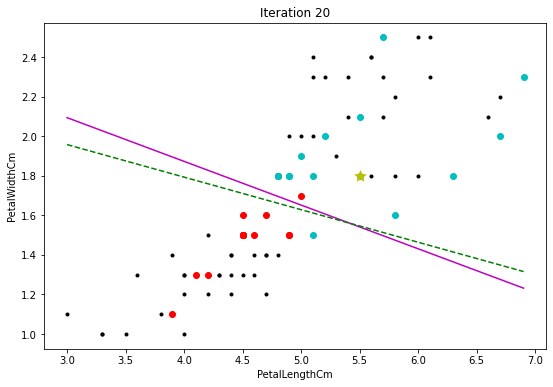

In [16]:
num = 20
t = []
for i in range(num):
    
    train_indexes.append(n)
    X_train = X_pool.iloc[train_indexes]
    y_train = y_pool.iloc[train_indexes]
    clf = LinearSVC()
    clf.fit(X_train, y_train)
    title, name = "Iteration "+ str(i+1), folder + ("rs1it5_%d.jpg" % (i+1))

    n = find_most_ambiguous(clf, unknown_indexes)
    unknown_indexes.remove(n)
    plot_svm(clf, train_indexes, unknown_indexes, n, title, name)
    filenames.append(name)